In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil import parser
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
import calendar
import random
import seaborn as sns
sns.set_theme(style="ticks", color_codes=True)

### To-do

Count TF for documents where a peak sentiment was observed.

### Functions

In [2]:
months_dict = {'Jan': '01',
 'Feb': '02',
 'Mar': '03',
 'Apr': '04',
 'May': '05',
 'Jun': '06',
 'Jul': '07',
 'Aug': '08',
 'Sep': '09',
 'Oct': '10',
 'Nov': '11',
 'Dec': '12'}

def format_given_datetime(date_string):
    tokens = date_string.split()
    return ""+tokens[-1]+"-"+months_dict[tokens[1]]+"-"+tokens[2]

def select_random_index(nrsamples, upper_bound):
    random_idx = []
    while len(random_idx) < nrsamples:
        random_value = random.randint(0, upper_bound)
        if random_value not in random_idx and random_value != upper_bound:
            random_idx.append(random_value)
    return random_idx

def get_random_sample_by_category(tweet_set, category, nrsamples):
    sample_tweet_text = []
    df_subset = tweet_set[tweet_set['sentiment'] == category]
    sample_idx = select_random_index(nrsamples, df_subset.shape[0])
    for i in sample_idx:
        sample_tweet_text.append(df_subset['text'].iloc[i])
    return sample_tweet_text

### Dataset loading

In [3]:
## PATHS

# hydrated_tweets_path = 'data/hydrated_tweets.csv'
hydrated_tweets_path = 'data/clean_tweets.csv'
sentiment_file_path = 'data/sentiment.tsv'

In [4]:
df_tweets = pd.read_csv(hydrated_tweets_path,
                        header=0,
                        usecols=[0,2,5,6],
                        encoding='utf-8',
                        skipinitialspace=True)
#                         nrows=100)

In [5]:
df_tweets.shape

(1511458, 4)

In [6]:
df_tweets

,favorite_count,text,created_at,retweet_count
0,0,Human-to-human transmission confirmed in China...,Mon Jan 20 17:04:22 +0000 2020,0
1,0,217 cases confirmed. But this new virus is not...,Mon Jan 20 17:04:05 +0000 2020,1
2,0,mention I had the coronavirus last year after ...,Mon Jan 20 17:22:25 +0000 2020,0
3,0,"mention That’s 💯 true , \nCorona virus \nswine...",Sat Jan 04 05:23:50 +0000 2020,0
4,0,mention Why #CCP keep on saying unknown cause ...,Thu Jan 09 10:38:40 +0000 2020,0
...,...,...,...,...
1511453,0,Piling on the fear for the simpletons....,Sat Jan 23 11:33:46 +0000 2021,0
1511454,0,With so much of chaos going on in the atmosphe...,Sat Jan 23 11:34:32 +0000 2021,0
1511455,1,The Covid-19 pandemic has altered everyone’s l...,Sat Jan 23 11:34:01 +0000 2021,0
1511456,0,mention (1) Another #deadcat to distract atten...,Sat Jan 23 11:33:46 +0000 2021,0


In [7]:
def is_string(text):
    return type(text) is not str

In [8]:
conds = df_tweets['text'].map(is_string)

In [9]:
df_tweets[conds]

,favorite_count,text,created_at,retweet_count
299621,0,NaN,Tue Apr 21 23:16:12 +0000 2020,0
302388,0,NaN,Tue Apr 21 23:24:23 +0000 2020,0


In [10]:
df_sentiment = pd.read_csv(sentiment_file_path,
                           sep='\t',
                           header=None,
                           names=['sentiment'],
                           skiprows=1,
                           usecols=[0])
#                            nrows=100)

In [11]:
df_sentiment.shape

(1511458, 1)

In [12]:
df_tweets_sentiment = df_tweets.join(df_sentiment)

In [13]:
# format date
only_dates = df_tweets_sentiment["created_at"]
only_dates = only_dates.map(format_given_datetime)
only_dates
df_tweets_sentiment = df_tweets_sentiment.drop(columns='created_at').join(only_dates)

In [14]:
# format sentiment
sentiments = df_tweets_sentiment['sentiment'].map({'neutral':0,'positive':1, 'negative':-1})
df_tweets_sentiment = df_tweets_sentiment.drop('sentiment', axis=1).join(sentiments)

In [15]:
# Month sampling
# df_tweets_sentiment = df_tweets_sentiment[(df_tweets_sentiment['created_at'] >= '2020-03-11') & (df_tweets_sentiment['created_at'] <= '2020-08-10')]
df_tweets_sentiment = df_tweets_sentiment[(df_tweets_sentiment['created_at'] >= '2020-03-11')]
df_tweets_sentiment.shape[0]

1447169

In [16]:
df_tweets_sentiment.head()

,favorite_count,text,retweet_count,created_at,sentiment
64289,0,‘It’s Just Everywhere Already’: How Delays in ...,0,2020-03-11,0
64290,3,There are two types of people in the world.\n\...,0,2020-03-11,0
64291,1,To mention so ya notice any similarities to th...,0,2020-03-11,0
64292,0,mention mention If anyone thinks Donald hasn’t...,0,2020-03-11,0
64293,0,Here we go! \nFirst coronavirus case reported ...,0,2020-03-11,0


### Tweet count by sentiment label

In [45]:
sentiment_count = df_tweets_sentiment['sentiment'] \
                    .groupby(df_tweets_sentiment['sentiment']) \
                    .count() \
                    .to_dict()
sentiment_count

{-1: 348526, 0: 773438, 1: 325205}

### Number of tweets per day

In [18]:
only_dates = df_tweets_sentiment["created_at"]
date_count = only_dates.groupby(only_dates).size()
date_count

created_at
2020-03-11    3845
2020-03-12    3910
2020-03-13    4007
2020-03-14    3920
2020-03-15    3810
              ... 
2021-01-16    4622
2021-01-18    4609
2021-01-20    4707
2021-01-21    4661
2021-01-23    4724
Name: created_at, Length: 291, dtype: int64

In [19]:
dates = np.array(date_count.index)
dates = np.vectorize(parser.isoparse)(dates)
frequency = np.array(date_count.values)

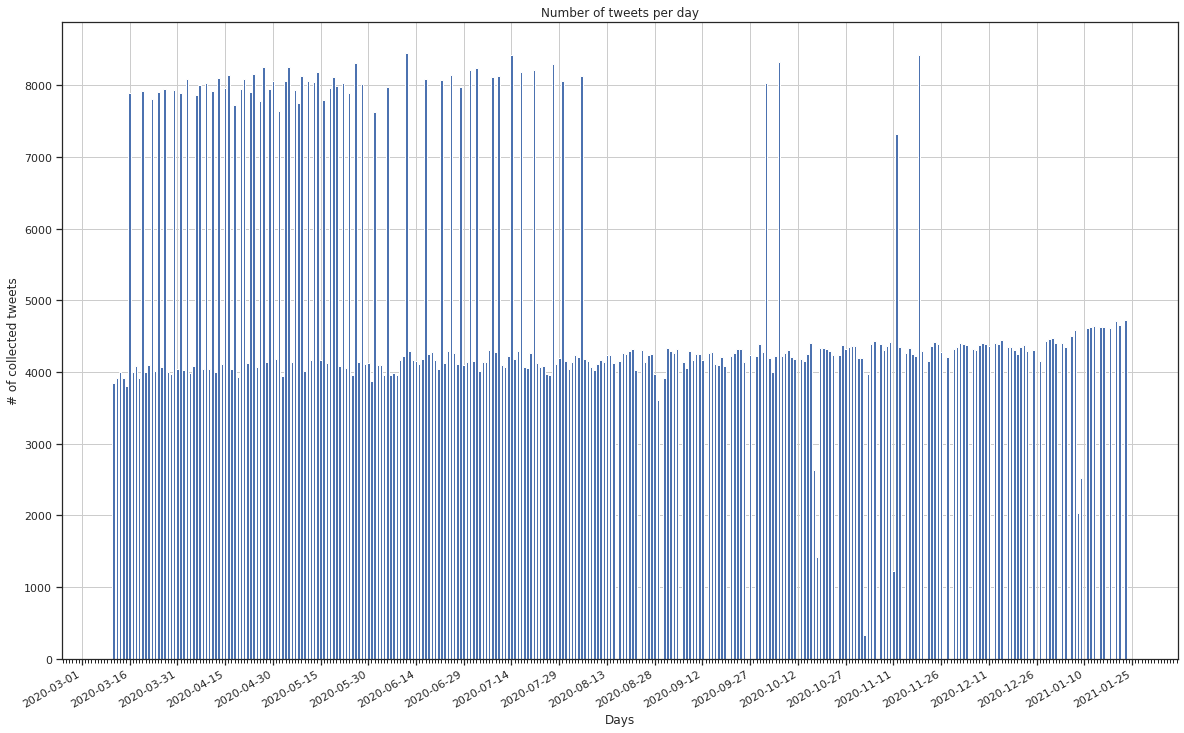

In [20]:
fig, ax = plt.subplots(figsize=(20,13))

ax.bar(dates, frequency)

# Major ticks every 6 months.
fmt_half_year = mdates.DayLocator(interval=15)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_day = mdates.DayLocator()
ax.xaxis.set_minor_locator(fmt_day)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# # Round to nearest years.
# datemin = np.datetime64(data['date'][0], 'Y')
# datemax = np.datetime64(data['date'][-1], 'Y') + np.timedelta64(1, 'Y')
# ax.set_xlim(datemin, datemax)

# Format the coords message box, i.e. the numbers displayed as the cursor moves
# across the axes within the interactive GUI.
ax.format_xdata = mdates.DateFormatter('%Y-%m')
ax.format_ydata = lambda x: f'${x:.2f}'  # Format the price.
ax.grid(True)

# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()

ax.set_xlabel('Days')  # Add an x-label to the axes.
ax.set_ylabel('# of collected tweets')  # Add a y-label to the axes.
ax.set_title("Number of tweets per day") 

plt.show()

### Random sampling by sentiment label

In [21]:
# neutral tweets
get_random_sample_by_category(df_tweets_sentiment[['text','sentiment']], 
                               0,
                               5)

['Covid-19 silencing the music, taking away good times  via mention',
 'How To Understand COVID-19 Numbers  via mention',
 '.mention BS..then he starts the lying accordion hands',
 'Coronavirus roundup: Developments in India and rest of world | India\xa0News',
 'mention mention mention mention mention mention See this is what I was talking abou…']

In [22]:
# positive tweets
get_random_sample_by_category(df_tweets_sentiment[['text','sentiment']], 
                               1,
                               5)

['As of 19 December, the United States had seen six cases of anaphylaxis among 272,001 people who received the COVID-…',
 'The Senate daycare that stayed open throughout all this even as schools have been closed. Because covid is a remark…',
 "#owlsofnite I didn't think it would be emotional but it truly is. Reaching 28 days makes me proud of the work we ha…",
 "Get that 'improved productivity' kinda feeling! You deserve it.\n\n#teamaccess #teamwork…",
 '.mention: I know you are committed to keeping all kids in #Greece healthy and safe through #COVID19. Hundred…']

In [23]:
# negative tweets
get_random_sample_by_category(df_tweets_sentiment[['text','sentiment']], 
                               -1,
                               5)

['mention mention and other mention   Reps-  mention just trashed your #AllLivesMattter propaganda bullshit.  He…',
 'mention Is there a cogent reason why you are still putting the lives of your staff at risk by askin them to c…',
 '‘That Is A Lie!’ Joe Scarborough Goes On Screaming Rant At Networks For Not Fact-Checking Trump During Live Press B…',
 'Preaching the Blues: Coronavirus In Schools: Teachers Fear For Their Lives #COVID__19',
 'Great composer dies at Age 42 🙏\nPls stay safe. Dont let your guard down in the opening up. Stay lockdown if you can…']

## Tweet exploration

In [21]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

In [22]:
def tokenize_text(text):
    size = len(text)
    terms = []
    for idx, sentence in enumerate(text):
        if type(sentence) is str:
            terms.append(word_tokenize(sentence))
        if idx % 250000 == 0:
            print(f'Done {idx}')
    return terms

from statistics import mean

def tokens_stats(tokenized_list):
    size_list = []
    for tokens in tokenized_list:
        size_list.append(len(tokens))
    return max(size_list), min(size_list), mean(size_list)

def remove_stopwords_punctuation(text):
    terms = []
    for tokens in text:
        #remove stopwords
        filtered_sentence = [w for w in tokens if not w.lower() in stop_words]
        #remove punctuation
        filtered_sentence = [word for word in filtered_sentence if word.isalnum()]
        terms.append(filtered_sentence)
    return terms

def count_frequency(terms_list):
    frequency = dict()
    for terms in terms_list:
        for term in terms:
            lw_term = term.lower()
            if lw_term in frequency:
                frequency[lw_term] += 1
            else:
                frequency[lw_term] = 1
    return frequency

In [23]:
tweets_text = df_tweets['text']
tweets_tokenized = tokenize_text(tweets_text)

Done 0
Done 250000
Done 500000
Done 750000
Done 1000000
Done 1250000
Done 1500000


### Sequence length Stats

In [62]:
print(f"-> max:{tokens_stats(tweets_tokenized)[0]} \n\
-> min:{tokens_stats(tweets_tokenized)[1]} \n\
-> mean:{tokens_stats(tweets_tokenized)[2]} \n ")

-> max:116 
        -> min:0 
        -> mean:16.688672379480447 
 


### Term Frequency for all dataset

In [24]:
tweets_no_swp = remove_stopwords_punctuation(tweets_tokenized)
terms_dict = count_frequency(tweets_no_swp)
top_20_terms_all=dict(sorted(terms_dict.items(), key=lambda item: item[1], reverse=True)[1:21])
top_20_terms_all

{'coronavirus': 352445,
 'covid19': 163898,
 'new': 88359,
 'cases': 86231,
 'people': 73952,
 'trump': 71796,
 'pandemic': 54889,
 'us': 51684,
 'via': 42473,
 'news': 42083,
 'get': 39628,
 'deaths': 39084,
 'vaccine': 38518,
 'one': 38343,
 'health': 37697,
 'like': 36930,
 'positive': 29895,
 'says': 28362,
 'time': 27603,
 'world': 27479}

In [27]:
#mem cleanup
del tweets_text
del tweets_tokenized
del tweets_no_swp
del terms_dict

NameError: name 'tweets_tokenized' is not defined

<AxesSubplot:title={'center':'Term frequency COVID-19 Dataset'}, xlabel='Frequency'>

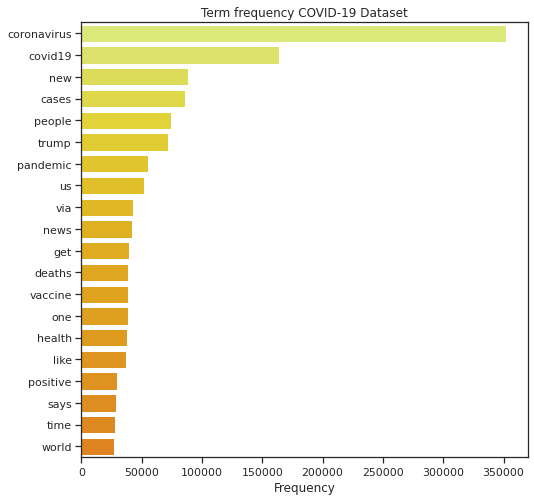

In [200]:
data_on_all = {
    'terms': list(top_20_terms_all.keys()),
    'frequency':list(top_20_terms_all.values())
}
plt.figure(figsize=(8,8))
plt.title('Term frequency COVID-19 Dataset')
plt.xlabel('Frequency')
sns.barplot(x='frequency',y='terms', data=data_on_all, palette="Wistia")

### Term Frequency by label: Negative

In [61]:
negative_tweets = df_tweets_sentiment[df_tweets_sentiment['sentiment'] == -1]
negative_tweets_text = negative_tweets['text']
negative_tweets_tokenized = tokenize_text(negative_tweets_text)
negative_tweets_no_swp = remove_stopwords_punctuation(negative_tweets_tokenized)
negative_terms_dict = count_frequency(negative_tweets_no_swp)
top_20_terms_negative=dict(sorted(negative_terms_dict.items(), key=lambda item: item[1], reverse=True)[1:21])
top_20_terms_negative

Done 0
Done 250000


{'coronavirus': 71586,
 'covid19': 32096,
 'trump': 30706,
 'people': 29920,
 'deaths': 13727,
 'pandemic': 13460,
 'us': 13041,
 'like': 11487,
 'get': 10947,
 'new': 10679,
 'one': 10288,
 'virus': 9061,
 'cases': 8841,
 'news': 8566,
 'death': 8481,
 'many': 8086,
 'due': 7513,
 'know': 7410,
 'via': 7294,
 'would': 7282}

In [62]:
#mem cleanup
del negative_tweets_text
del negative_tweets_tokenized
del negative_tweets_no_swp
del negative_terms_dict

### Term Frequency by label: Neutral

In [63]:
neutral_tweets = df_tweets_sentiment[df_tweets_sentiment['sentiment'] == 0]
neutral_tweets_text = neutral_tweets['text']
neutral_tweets_tokenized = tokenize_text(neutral_tweets_text)
neutral_tweets_no_swp = remove_stopwords_punctuation(neutral_tweets_tokenized)
neutral_terms_dict = count_frequency(neutral_tweets_no_swp)
top_20_terms_neutral=dict(sorted(neutral_terms_dict.items(), key=lambda item: item[1], reverse=True)[1:21])
top_20_terms_neutral

Done 0
Done 250000
Done 500000
Done 750000


{'coronavirus': 190104,
 'covid19': 88155,
 'cases': 65271,
 'new': 60574,
 'trump': 32524,
 'pandemic': 30941,
 'people': 29048,
 'via': 27422,
 'us': 23932,
 'vaccine': 23414,
 'health': 22639,
 'news': 22223,
 'positive': 21405,
 'deaths': 21254,
 'says': 17587,
 'one': 17272,
 'get': 17170,
 'like': 14985,
 'today': 14552,
 'covid': 14452}

In [64]:
#mem cleanup
del neutral_tweets_tokenized
del neutral_tweets_no_swp
del neutral_terms_dict

### Term Frequency by label: Positive

In [65]:
positive_tweets = df_tweets_sentiment[df_tweets_sentiment['sentiment'] == 1]
positive_tweets_text = positive_tweets['text']
positive_tweets_tokenized = tokenize_text(positive_tweets_text)
positive_tweets_no_swp = remove_stopwords_punctuation(positive_tweets_tokenized)
positive_terms_dict = count_frequency(positive_tweets_no_swp)
top_20_terms_positive=dict(sorted(positive_terms_dict.items(), key=lambda item: item[1], reverse=True)[1:21])
top_20_terms_positive

Done 0
Done 250000


{'covid19': 39930,
 'coronavirus': 35701,
 'good': 14853,
 'new': 13157,
 'us': 12114,
 'people': 11782,
 'great': 11534,
 'get': 9913,
 'pandemic': 9692,
 'one': 9477,
 'thank': 9023,
 'like': 8884,
 'well': 8657,
 'news': 8524,
 'vaccine': 8407,
 'thanks': 8350,
 'help': 8004,
 'cases': 7941,
 'time': 7609,
 'today': 6725}

In [66]:
#mem cleanup
del positive_tweets_tokenized
del positive_tweets_no_swp
del positive_terms_dict

### Plotting

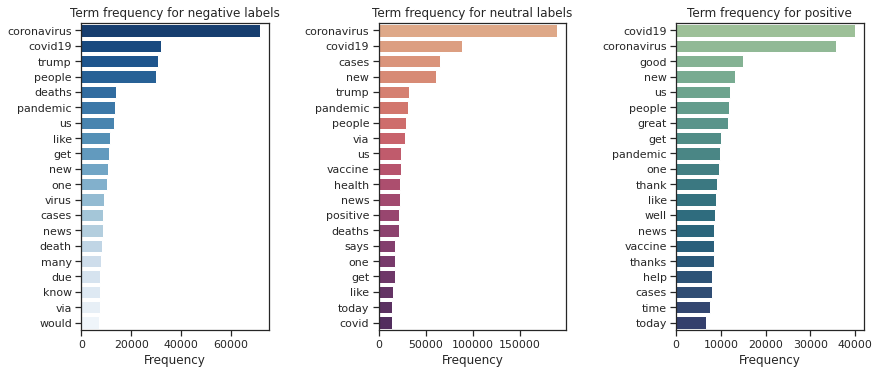

In [67]:
data_negatives = {
    'terms': list(top_20_terms_negative.keys()),
    'frequency':list(top_20_terms_negative.values())
}
data_neutral = {
    'terms': list(top_20_terms_neutral.keys()),
    'frequency':list(top_20_terms_neutral.values())
}
data_positive = {
    'terms': list(top_20_terms_positive.keys()),
    'frequency':list(top_20_terms_positive.values())
}

f = plt.figure(figsize=(13, 6))
gs = f.add_gridspec(1, 3)

ax = f.add_subplot(gs[0, 0])
ax.set_title('Term frequency for negative labels')
ax.set_xlabel('Frequency')
sns.barplot(x='frequency',y='terms', data=data_negatives, palette="Blues_r")

ax = f.add_subplot(gs[0, 1])
ax.set_title('Term frequency for neutral labels')
ax.set_xlabel('Frequency')
sns.barplot(x='frequency',y='terms', data=data_neutral, palette="flare")

ax = f.add_subplot(gs[0, 2])
ax.set_title('Term frequency for positive')
ax.set_xlabel('Frequency')
sns.barplot(x='frequency',y='terms', data=data_positive, palette="crest")

f.tight_layout(pad=3.0)

### Daily sentiment variance

In [68]:
sorted_df = df_tweets_sentiment[['sentiment','created_at']].sort_values(by=['created_at'])

In [69]:
sorted_df = sorted_df.groupby(by='created_at').mean()

In [14]:
sentiment_mean = np.array(sorted_df.values)

In [15]:
dates = np.array(sorted_df.index)
dates = np.vectorize(parser.isoparse)(dates)

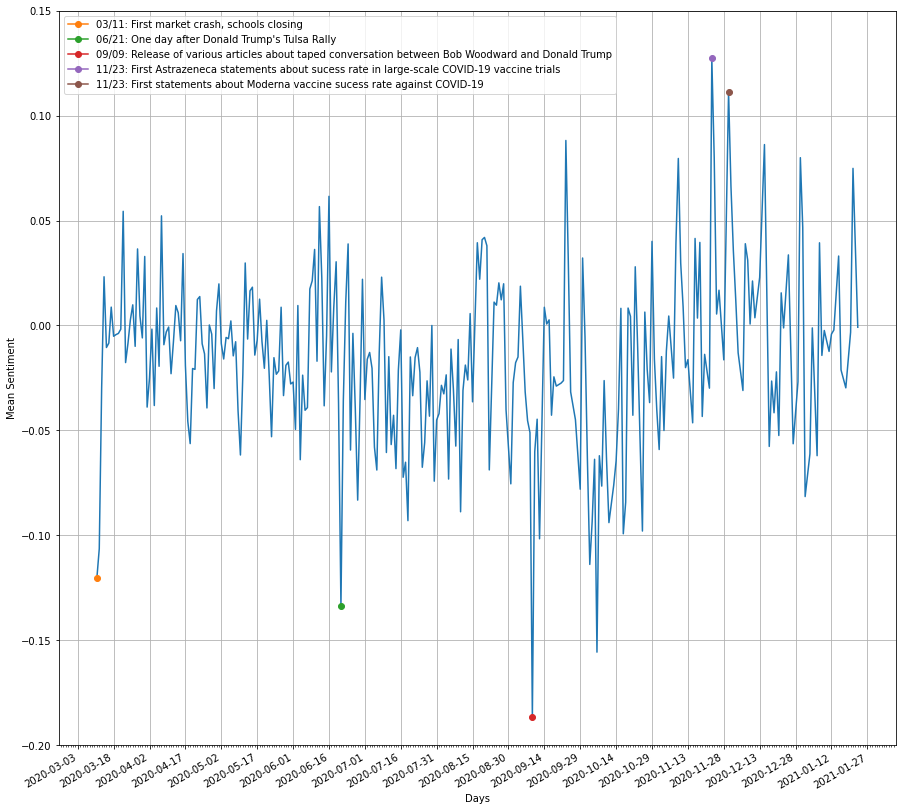

In [46]:
fig, ax = plt.subplots(figsize=(15,15))
# fig, ax = plt.subplots(figsize=(30,20))

# main plot
ax.plot(dates, sentiment_mean)

# YY axis
# y_0 = [0]*dates.size
# ax.plot(dates, y_0)

# np.linspace(-0.5,0.5,100)


date_1 = parser.isoparse('2020-03-11')
ax.plot(date_1, sorted_df.loc['2020-03-11'], marker='o', label='03/11: First market crash, schools closing')

# Trump's Tulsa Rally
date_2 = parser.isoparse('2020-06-21')
ax.plot(date_2, sorted_df.loc['2020-06-21'], marker='o', label='06/21: One day after Donald Trump\'s Tulsa Rally')

# Release of various articles about taped conversation between Bob Woodward and Donald Trump
date_3 = parser.isoparse('2020-09-09')
ax.plot(date_3, sorted_df.loc['2020-09-09'], marker='o', label='09/09: Release of various articles about taped conversation between Bob Woodward and Donald Trump')

date_5 = parser.isoparse('2020-11-23')
ax.plot(date_5, sorted_df.loc['2020-11-23'], marker='o', label='11/23: First Astrazeneca statements about sucess rate in large-scale COVID-19 vaccine trials')

date_6 = parser.isoparse('2020-11-30')
ax.plot(date_6, sorted_df.loc['2020-11-30'], marker='o', label='11/23: First statements about Moderna vaccine sucess rate against COVID-19')


# Major ticks every 15 days.
fmt_half_year = mdates.DayLocator(interval=15)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every day.
fmt_day = mdates.DayLocator()
ax.xaxis.set_minor_locator(fmt_day)

# Tick limits
ax.set_ylim(-0.2, 0.15)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# # Round to nearest years.
# datemin = np.datetime64(data['date'][0], 'Y')
# datemax = np.datetime64(data['date'][-1], 'Y') + np.timedelta64(1, 'Y')
# ax.set_xlim(datemin, datemax)

# Format the coords message box, i.e. the numbers displayed as the cursor moves
# across the axes within the interactive GUI.
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: f'${x:.2f}'  # Format the price.
ax.grid(True)

# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()

ax.set_xlabel('Days')  # Add an x-label to the axes.
ax.set_ylabel('Mean Sentiment')  # Add a y-label to the axes.
# ax.set_title("Simple Plot")

ax.legend()

plt.show()

In [155]:
data = sorted_df.values

median = np.median(data)
upper_quartile = np.percentile(data, 75)
lower_quartile = np.percentile(data, 25)

iqr = upper_quartile - lower_quartile
upper_whisker = data[data<=upper_quartile+1.5*iqr].max()
lower_whisker = data[data>=lower_quartile-1.5*iqr].min()

In [162]:
outlier_dict = dict()

for idx, value in enumerate(data):
    if value > upper_whisker or value < lower_whisker:
        day = sorted_df.index[idx]
        outlier_dict[day] = value[0]

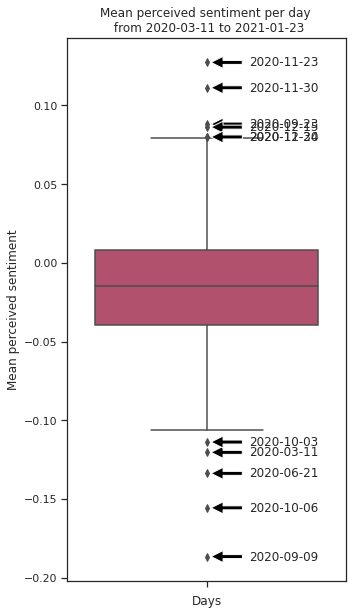

In [193]:
fig, ax = plt.subplots(figsize=(5,10))

# main plot
boxplot = sns.boxplot(data=sorted_df, palette='flare')

plt.title('Mean perceived sentiment per day \n from 2020-03-11 to 2021-01-23')
# ax.set_xlabel('x label')  # Add an x-label to the axes.
plt.ylabel('Mean perceived sentiment')
plt.xlabel('Days')
ax.xaxis.set_major_formatter("")

for key, value in outlier_dict.items():
#     plt.text(value, value, f'{key}', ha='right', va='center')
    plt.annotate(f'{key}', (0, value),
                 xytext=(0.4,value),
                 xycoords='data',
                 arrowprops=dict(facecolor='black', shrink=0.1),
                 ha='right', va='center')

plt.show()

### Daily sentiment variance 2

In [18]:
sorted_df = df_tweets_sentiment[['sentiment','created_at']].sort_values(by=['created_at'])

In [19]:
group_size = sorted_df.groupby(by='created_at').size()

In [20]:
group_sentiment_size = sorted_df.groupby(by=['created_at','sentiment']).size()

In [21]:
for key, value in group_sentiment_size.items():
    group_sentiment_size.loc[key] = int(value / group_size[key[0]] * 100)

In [22]:
group_sentiment_size

created_at  sentiment
2020-03-11  -1           26
             0           59
             1           14
2020-03-12  -1           25
             0           58
                         ..
2021-01-21   0           53
             1           27
2021-01-23  -1           21
             0           56
             1           21
Length: 873, dtype: int64

In [23]:
negative_sentiment_portion = group_sentiment_size.loc[:,-1]
neutral_sentiment_portion = group_sentiment_size.loc[:,0]
positive_sentiment_portion = group_sentiment_size.loc[:,1]
dates = np.array(group_size.index)
dates = np.vectorize(parser.isoparse)(dates)

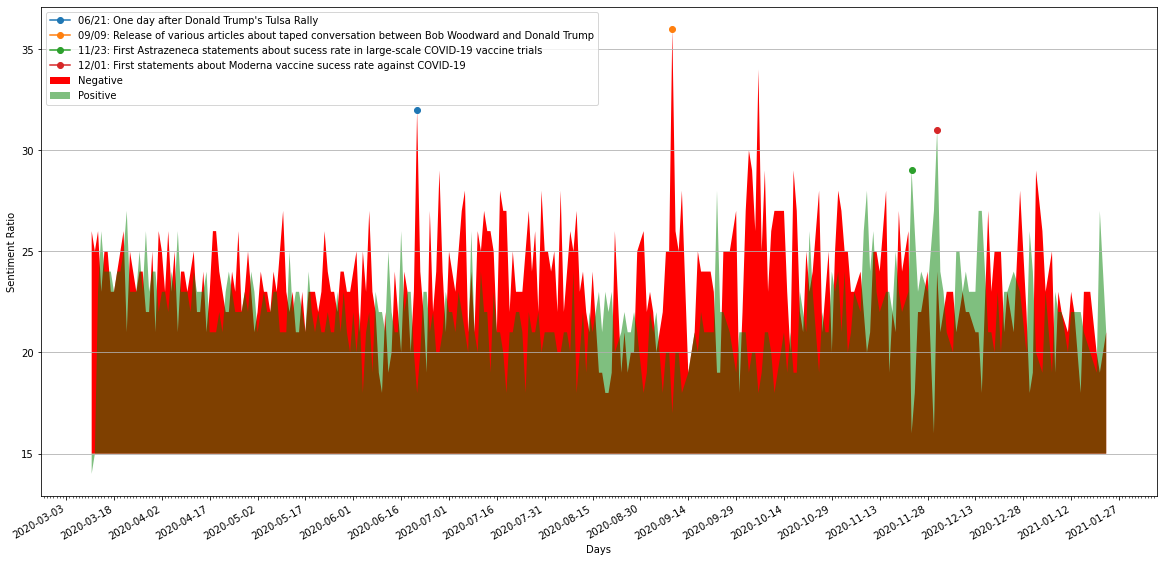

In [25]:
fig, ax = plt.subplots(figsize=(20,10))
# fig, ax = plt.subplots(figsize=(30,20))

# main plot
# ax.plot(dates, negative_sentiment_portion, color='red', fillstyle='full', label='Negative')
ax.fill_between(dates,15, negative_sentiment_portion, facecolor='red', alpha=1, label='Negative')
# ax.plot(dates, neutral_sentiment_portion)
# ax.plot(dates, positive_sentiment_portion, color='green', label='Positive')
ax.fill_between(dates,15, positive_sentiment_portion, facecolor='green', alpha=0.5, label='Positive')

# YY axis
# y_0 = [0]*dates.size
# ax.plot(dates, y_0)

# np.linspace(-0.5,0.5,100)


# Trump's Tulsa Rally
date_2 = parser.isoparse('2020-06-21')
ax.plot(date_2, negative_sentiment_portion.loc['2020-06-21'], marker='o', label='06/21: One day after Donald Trump\'s Tulsa Rally')

# Release of various articles about taped conversation between Bob Woodward and Donald Trump
date_3 = parser.isoparse('2020-09-09')
ax.plot(date_3, negative_sentiment_portion.loc['2020-09-09'], marker='o', label='09/09: Release of various articles about taped conversation between Bob Woodward and Donald Trump')

date_5 = parser.isoparse('2020-11-23')
ax.plot(date_5, positive_sentiment_portion.loc['2020-11-23'], marker='o', label='11/23: First Astrazeneca statements about sucess rate in large-scale COVID-19 vaccine trials')

date_6 = parser.isoparse('2020-12-01')
ax.plot(date_6, positive_sentiment_portion.loc['2020-12-01'], marker='o', label='12/01: First statements about Moderna vaccine sucess rate against COVID-19')


# Major ticks every 15 days.
fmt_half_year = mdates.DayLocator(interval=15)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every day.
fmt_day = mdates.DayLocator()
ax.xaxis.set_minor_locator(fmt_day)

# Tick limits
# ax.set_ylim(-0.2, 0.15)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# # Round to nearest years.
# datemin = np.datetime64(data['date'][0], 'Y')
# datemax = np.datetime64(data['date'][-1], 'Y') + np.timedelta64(1, 'Y')
# ax.set_xlim(datemin, datemax)

# Format the coords message box, i.e. the numbers displayed as the cursor moves
# across the axes within the interactive GUI.
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: f'${x:.2f}'  # Format the price.
# ax.grid(True)
ax.yaxis.grid(True)

# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()

ax.set_xlabel('Days')  # Add an x-label to the axes.
ax.set_ylabel('Sentiment Ratio')  # Add a y-label to the axes.
# ax.set_title("Simple Plot")

ax.legend()

plt.show()

### Term Frequency by Date

### 2020-06-21

In [75]:
tweets_on_06_21 = df_tweets_sentiment.loc[df_tweets_sentiment['created_at']=='2020-06-21', ['text']]

Done 0


<AxesSubplot:>

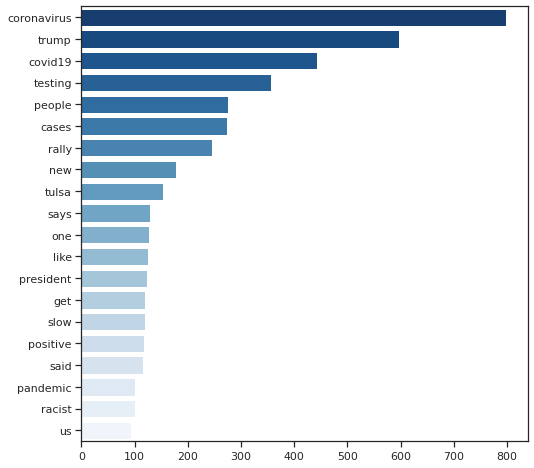

In [141]:
text_on_06_21 = tweets_on_06_21['text']
tokenized_on_06_21 = tokenize_text(text_on_06_21)
no_swp_on_06_21 = remove_stopwords_punctuation(tokenized_on_06_21)
terms_dict_on_06_21 = count_frequency(no_swp_on_06_21)
top_20_terms_on_06_21 = dict(sorted(terms_dict_on_06_21.items(), key=lambda item: item[1], reverse=True)[1:21])
data_on_06_21 = {
    'terms': list(top_20_terms_on_06_21.keys()),
    'frequency':list(top_20_terms_on_06_21.values())
}
plt.figure(figsize=(8,8))
sns.barplot(x='frequency',y='terms', data=data_on_06_21, palette="Blues_r")

### 2020-09-09

Done 0


<AxesSubplot:>

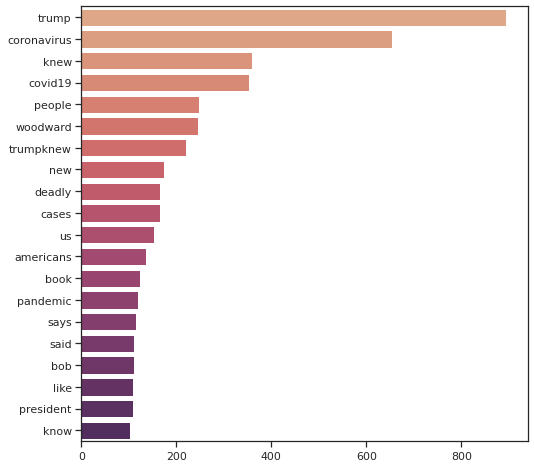

In [140]:
tweets_on_09_09 = df_tweets_sentiment.loc[df_tweets_sentiment['created_at']=='2020-09-09', ['text']]
text_on_09_09 = tweets_on_09_09['text']
tokenized_on_09_09 = tokenize_text(text_on_09_09)
no_swp_on_09_09 = remove_stopwords_punctuation(tokenized_on_09_09)
terms_dict_on_09_09 = count_frequency(no_swp_on_09_09)
top_20_terms_on_09_09 = dict(sorted(terms_dict_on_09_09.items(), key=lambda item: item[1], reverse=True)[1:21])

data_on_09_09 = {
    'terms': list(top_20_terms_on_09_09.keys()),
    'frequency':list(top_20_terms_on_09_09.values())
}
plt.figure(figsize=(8,8))
sns.barplot(x='frequency',y='terms', data=data_on_09_09, palette="flare")

### 2020-11-23

Done 0


<AxesSubplot:>

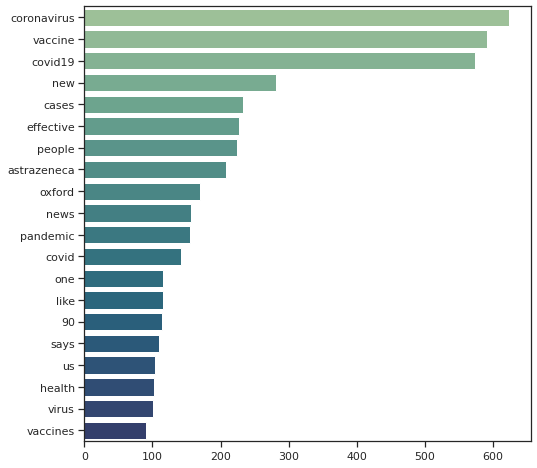

In [98]:
tweets_on_11_23 = df_tweets_sentiment.loc[df_tweets_sentiment['created_at']=='2020-11-23', ['text']]
text_on_11_23 = tweets_on_11_23['text']
tokenized_on_11_23 = tokenize_text(text_on_11_23)
no_swp_on_11_23 = remove_stopwords_punctuation(tokenized_on_11_23)
terms_dict_on_11_23 = count_frequency(no_swp_on_11_23)
top_20_terms_on_11_23 = dict(sorted(terms_dict_on_11_23.items(), key=lambda item: item[1], reverse=True)[1:21])

data_on_11_23 = {
    'terms': list(top_20_terms_on_11_23.keys()),
    'frequency':list(top_20_terms_on_11_23.values())
}
plt.figure(figsize=(8,8))
sns.barplot(x='frequency',y='terms', data=data_on_11_23, palette="crest")

### 2020-12-01

Done 0


<AxesSubplot:>

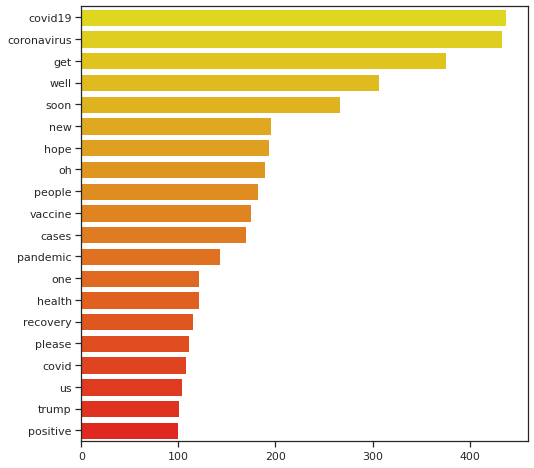

In [124]:
tweets_on_12_01 = df_tweets_sentiment.loc[df_tweets_sentiment['created_at']=='2020-12-01', ['text']]
text_on_12_01 = tweets_on_12_01['text']
tokenized_on_12_01 = tokenize_text(text_on_12_01)
no_swp_on_12_01 = remove_stopwords_punctuation(tokenized_on_12_01)
terms_dict_on_12_01 = count_frequency(no_swp_on_12_01)
top_20_terms_on_12_01 = dict(sorted(terms_dict_on_12_01.items(), key=lambda item: item[1], reverse=True)[1:21])

data_on_12_01 = {
    'terms': list(top_20_terms_on_12_01.keys()),
    'frequency':list(top_20_terms_on_12_01.values())
}


plt.figure(figsize=(8,8))
sns.barplot(x='frequency',y='terms', data=data_on_12_01, palette="autumn_r")

In [126]:
data_on_12_01['day'] = ['2020-12-01']*20
data_on_11_23['day'] = ['2020-11-23']*20

In [128]:
df_on_12_01 = pd.DataFrame.from_dict(data_on_12_01)
df_on_11_23 = pd.DataFrame.from_dict(data_on_11_23)

In [130]:
df_for_image = pd.concat([df_on_12_01, df_on_11_23])

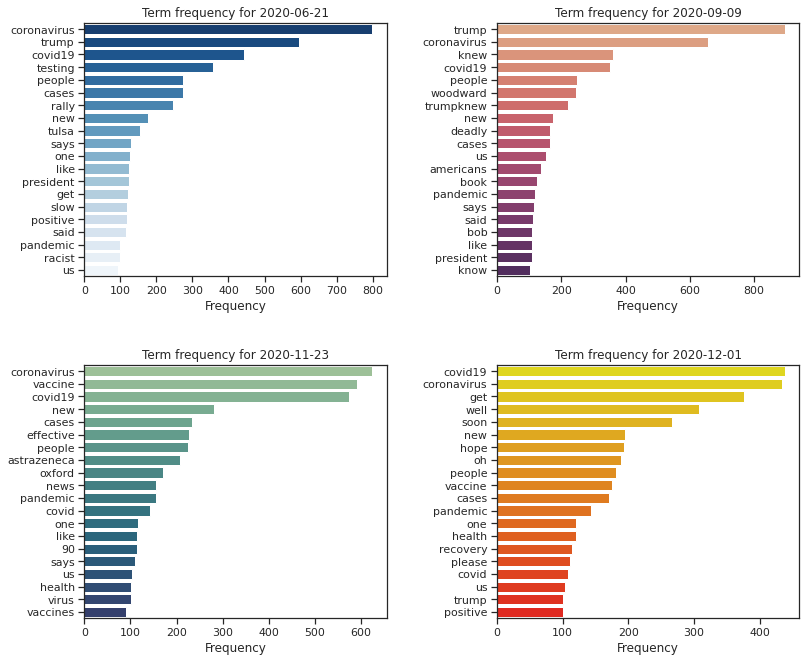

In [155]:
f = plt.figure(figsize=(12, 10))
gs = f.add_gridspec(2, 2)

ax = f.add_subplot(gs[0, 0])
ax.set_title('Term frequency for 2020-06-21')
ax.set_xlabel('Frequency')
sns.barplot(x='frequency',y='terms', data=data_on_06_21, palette="Blues_r")

ax = f.add_subplot(gs[0, 1])
ax.set_title('Term frequency for 2020-09-09')
ax.set_xlabel('Frequency')
sns.barplot(x='frequency',y='terms', data=data_on_09_09, palette="flare")

ax = f.add_subplot(gs[1, 0])
ax.set_title('Term frequency for 2020-11-23')
ax.set_xlabel('Frequency')
sns.barplot(x='frequency',y='terms', data=data_on_11_23, palette="crest")

ax = f.add_subplot(gs[1, 1])
ax.set_title('Term frequency for 2020-12-01')
ax.set_xlabel('Frequency')
sns.barplot(x='frequency',y='terms', data=data_on_12_01, palette="autumn_r")

f.tight_layout(pad=3.0)

# check trump correlation with observed spikes

20/06
Trump's tulsa rally with a significant number of attendants amidst the covid-19 pandemic.
Trump stated he demand to slow covid-19 testing
Trump

21/06
Trump seems to have said that not many people had died from covid.
Trump seems to have said that he slowed down testing deliberatelly


#### September 9, 2020 - Release of various articles about taped conversation between Bob Woodward and Donald Trump
On Feb. 7, during a taped interview with Bob Woodward, President Trump acknowledged that the coronavirus could be transmitted through the air, that it was very dangerous and that it would be difficult to contain. “This is deadly stuff,” he told the investigative journalist.

Despite his apparent understanding of the severity of the disease and its method of transmission, over the next month, in five cities around the country, Mr. Trump held large indoor rallies, which were attended by thousands of his supporters.

Why lie to the American people? Why — as the administration accuses the Chinese government of doing — lie to the world about the severity of what was declared a pandemic only days later?

“I wanted to always play it down,” Mr. Trump told Mr. Woodward on March 19. “I still like playing it down, because I don’t want to create a panic.”

Mr. Trump and a great many of his supporters and political allies did play down the severity of the coronavirus and did criticize the public health measures deployed to prevent its spread. As a result, the coronavirus spread faster and sickened or killed more people in the United States than in any of its peer nations.

Furthermore, Mr. Woodward’s tapes make clear that members of the Trump administration failed to act.

#### October 02, 2020 - trump says he and his wife have covid

#### October 02, 2020 - trump actions endangers others

Trump briefly leaves his Walter Reed hospital room to drive by supporters, prompting outcry from medical experts and Democrats who claimed the move endangered Trump’s entourage.

#### November 23, 2020 - Astrazeneca vaccine met primary efficacy endpoint in preventing COVID-19

#### November 30, 2020 - Moderna vaccine states 100% effectiveness against COVID-19